In [1]:
import librosa
import numpy as np
import pyworld as pw
import os
import tensorflow as tf
import pandas as pd

### Features are already extracted for malayalam audio dataset

In [2]:
import scipy.io
path = r"E:\Anjali\MODEL\Malayalam\ap_f0_mfb_features_mal.mat"
df=scipy.io.loadmat(path)
df.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Features', 'P_id', 'Score', 'Category'])

In [3]:
features = np.hstack(df['Features'])
label1 = np.hstack(df['Score'])
label2 = np.hstack(df['Category'])

In [4]:
# Define the segment length
segment_length = 100  # Choose a suitable segment length based on your data

# Initialize lists to store segmented features and labels
segmented_features = []
segmented_label1 = []
segmented_label2 =[]

# Iterate over each audio clip
for i in range(len(features)):
    # Get the current audio clip and its corresponding label
    current_features = features[i]
    current_label1 = label1[i]
    current_label2 = label2[i]

    # Calculate the number of segments for this audio clip
    num_segments = len(current_features) // segment_length

    # Iterate over each segment
    for j in range(num_segments):
        # Calculate the start and end indices for the current segment
        start_idx = j * segment_length
        end_idx = start_idx + segment_length

        # Extract the segment of features and its corresponding label
        segment_features = current_features[start_idx:end_idx]

        # Append the segmented features and label to the lists
        segmented_features.append(segment_features)
        segmented_label1.append(current_label1)
        segmented_label2.append(current_label2)

# Convert the segmented features and labels to numpy arrays
segmented_features = np.array(segmented_features)
regression_label = np.array(segmented_label1)
classification_label = np.array(segmented_label2)

# Check the shape of the segmented features and labels
print("Shape of segmented features:", segmented_features.shape)
print("Shape of regression_labels:", regression_label.shape)
print("Shape of classification_labels:", classification_label.shape)


Shape of segmented features: (19588, 100, 38)
Shape of regression_labels: (19588,)
Shape of classification_labels: (19588,)


In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train_regression,y_test_regression,y_train_classification,y_test_classification = train_test_split(segmented_features,regression_label,classification_label,test_size=0.2, random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train_regression.shape)
print(y_test_regression.shape)
print(y_train_classification.shape)
print(y_test_classification.shape)

(15670, 100, 38)
(3918, 100, 38)
(15670,)
(3918,)
(15670,)
(3918,)


In [6]:
import tensorflow as tf

# Define the categories
categories = ['None', 'Mild', 'Moderate', 'Moderately severe', 'Severe']

# Convert categories to one-hot encoded format
y_train_classification_onehot = tf.keras.utils.to_categorical(y_train_classification, num_classes=len(categories))
y_test_classification_onehot = tf.keras.utils.to_categorical(y_test_classification, num_classes=len(categories))

print(y_test_classification_onehot)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


## LSTM MODEL

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

input_shape=(100,38)

model = Sequential()

# Add an LSTM layer with 128 units and input_shape=(100,38)
model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.3))

# Add a single LSTM layer with 64 units
model.add(LSTM(64))
model.add(Dropout(0.3))

# Add dense layers with relu activation
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Add a dropout layer
model.add(Dropout(0.2))

# Add output layer with softmax activation
model.add(Dense(5, activation='softmax'))

model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train_classification_onehot,
                    validation_data=(x_test, y_test_classification_onehot),
                    epochs=40, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
evaluation_results = model.evaluate(x_test, y_test_classification_onehot)

# Print the evaluation results
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          85504     
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [8]:
from tensorflow.keras.models import load_model

# Specify the path to the saved model file
model_path = "E:\Anjali\MODEL\Malayalam\LSTM_20E_final"  # Update this with the actual path

# Load the saved model
lstm_model = load_model(model_path)

In [9]:
# Evaluate the model
lstm_evaluation_results = lstm_model.evaluate(x_test, y_test_classification_onehot)

# Print the evaluation results
print("Test Loss:", lstm_evaluation_results[0])
print("Test Accuracy:", lstm_evaluation_results[1])

123/123 [==============================] - 5s 32ms/step - loss: 0.9534 - accuracy: 0.7335
Test Loss: 0.953403115272522
Test Accuracy: 0.733537495136261


In [10]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          85504     
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

## CNN MODEL

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_classification_model(input_shape, dropout_rate=0.5, learning_rate=0.001):
    input_layer = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv1D(32, 5, activation='relu')(input_layer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(64, 3, activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    flatten = Flatten()(pool2)

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(dropout_rate)(dense1)

    # Output layer for classification
    classification_output = Dense(5, activation='softmax', name='classification_output')(dropout)

    # Create the model
    model = tf.keras.Model(inputs=input_layer, outputs=classification_output)

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the input shape based on the shape of a single segment
input_shape = (100, 38)  # Shape of a single segment

# Create the classification model
classification_model = create_classification_model(input_shape)

# Display model summary
classification_model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = classification_model.fit(x_train, y_train_classification_onehot,
                                   validation_data=(x_test, y_test_classification_onehot),
                                   epochs=20, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
evaluation_results = classification_model.evaluate(x_test, y_test_classification_onehot)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 38)]         0         
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            6112      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1472)              0     

In [11]:
from tensorflow.keras.models import load_model

# Specify the path to the saved model file
model_path = "E:\Anjali\MODEL\Malayalam\CNN_20E_final"  # Update this with the actual path

# Load the saved model
cnn_model = load_model(model_path)

In [12]:
# Evaluate the model
cnn_evaluation_results = cnn_model.evaluate(x_test, y_test_classification_onehot)

# Print the evaluation results
print("Test Loss:", cnn_evaluation_results[0])
print("Test Accuracy:", cnn_evaluation_results[1])

123/123 [==============================] - 1s 4ms/step - loss: 1.1071 - accuracy: 0.5462
Test Loss: 1.1071135997772217
Test Accuracy: 0.5461970567703247


In [13]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 38)]         0         
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            6112      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1472)              0     

## Bi-LSTM

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (100, 38)

model = Sequential()

# Add a Bidirectional LSTM layer with 128 units and input_shape=(100,38)
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
model.add(Dropout(0.4))  # Increased dropout rate for the first layer

# Add another Bidirectional LSTM layer with 32 units
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))  # Increased dropout rate for the second layer

# Add dense layers with relu activation and L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization added
model.add(Dense(64, activation='relu'))

# Add a dropout layer
model.add(Dropout(0.6))  # Increased dropout rate for the final dropout layer

# Add output layer with softmax activation
model.add(Dense(5, activation='softmax'))

model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.99)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train_classification_onehot,
                    validation_data=(x_test, y_test_classification_onehot),
                    epochs=30, batch_size=32,callbacks=[early_stopping])

# Evaluate the model
evaluation_results = model.evaluate(x_test, y_test_classification_onehot)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 256)         171008    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8

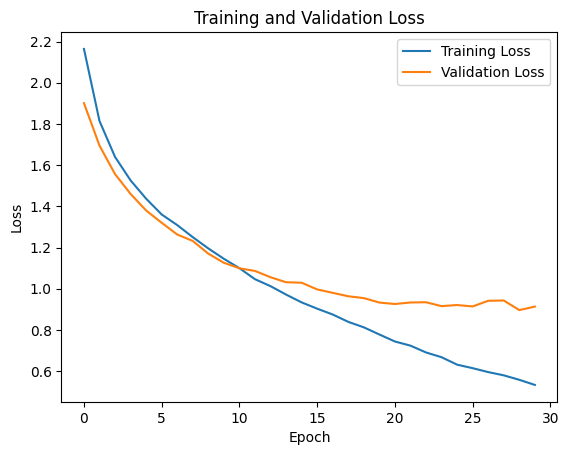

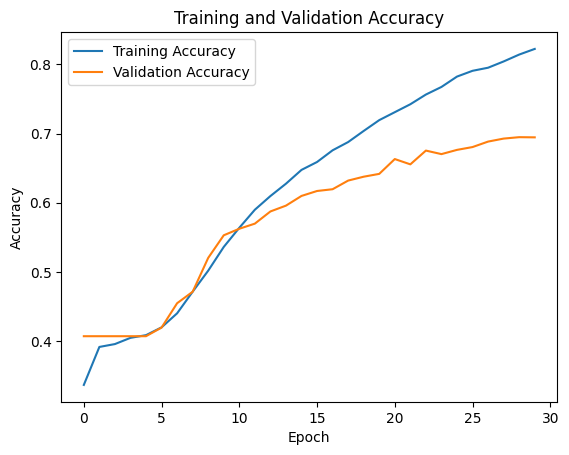

In [8]:
import matplotlib.pyplot as plt
# Plot training and validation loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
model.save("E:\Anjali\MODEL\Malayalam\BiLSTM_20E_good_69")

INFO:tensorflow:Assets written to: E:\Anjali\MODEL\Malayalam\BiLSTM_20E_good_69\assets


INFO:tensorflow:Assets written to: E:\Anjali\MODEL\Malayalam\BiLSTM_20E_good_69\assets


In [15]:
from tensorflow.keras.models import load_model

# Specify the path to the saved model file
model_path = "E:\Anjali\MODEL\Malayalam\BiLSTM_20E_good"  # Update this with the actual path

# Load the saved model
bilstm_model = load_model(model_path)

In [16]:
# Evaluate the model
bilstm_evaluation_results = bilstm_model.evaluate(x_test, y_test_classification_onehot)

# Print the evaluation results
print("Test Loss:", bilstm_evaluation_results[0])
print("Test Accuracy:", bilstm_evaluation_results[1])

123/123 [==============================] - 8s 54ms/step - loss: 0.9474 - accuracy: 0.6483
Test Loss: 0.9474031329154968
Test Accuracy: 0.6482899188995361


In [17]:
print("CNN MODEL")
#cnn_model.summary()
print("Test Loss:", cnn_evaluation_results[0])
print("Test Accuracy:", cnn_evaluation_results[1])

print("LSTM MODEL")
#lstm_model.summary()
print("Test Loss:", lstm_evaluation_results[0])
print("Test Accuracy:", lstm_evaluation_results[1])

print("Bi-LSTM MODEL")
#bilstm_model.summary()
print("Test Loss:", bilstm_evaluation_results[0])
print("Test Accuracy:", bilstm_evaluation_results[1])

CNN MODEL
Test Loss: 1.1071135997772217
Test Accuracy: 0.5461970567703247
LSTM MODEL
Test Loss: 0.953403115272522
Test Accuracy: 0.733537495136261
Bi-LSTM MODEL
Test Loss: 0.9474031329154968
Test Accuracy: 0.6482899188995361
